In [2]:
import random

# StringIO behaves like a file object 
from io import StringIO 

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import matplotlib as mpl
from sklearn.datasets import load_boston
from sklearn import linear_model
from sklearn.metrics import r2_score
from sklearn.pipeline import make_pipeline
from sklearn.preprocessing import PolynomialFeatures
from sklearn.preprocessing import StandardScaler
import statsmodels.api as sm
import statsmodels.formula.api as smf
%matplotlib inline 

In [3]:
class CqkProblem:
    def __init__(self, r, n, d, a, b, low, up):
        self.n = n
        self.r = r
        self.d = list(d)
        self.a = list(a)
        self.b = list(b)
        self.low = list(low)
        self.up = list(up)

In [4]:
def generate_cqk_problem(n):
    d = []
    low = []
    up = []
    b = []
    a = []
    temp = 0
    lb = 0.0
    ub = 0.0
    lower = 10
    upper = 25
    r = 0

    for i in range(n):
        
        b.append(10 + 14*random.random())
        low.append(1 + 14*random.random())
        up.append(1 + 14*random.random())
        if low[i] > up[i]:
            temp = low[i]
            low[i] = up[i]
            up[i] = temp
        
        lb = lb + b[i]*low[i];
        ub = ub + b[i]*up[i];
        
        #Uncorrelated
        d.append(random.randint(10,25))
        a.append(random.randint(10,25))
        
    r = lb + (ub - lb)*0.7;
    
    return CqkProblem( r, n, d, a, b, low, up)

In [5]:

def initial_lambda(p, lamb):
    s0=0.0
    q0=0.0
    slopes = []
    for i in range(p.n):
        slopes.append((p.b[i]/p.d[i])*p.b[i])
        s0 = s0 + (p.a[i] * p.b[i]) / p.d[i]
        q0 = q0 + (p.b[i] * p.b[i]) / p.d[i]
    lamb = (p.r-s0)/q0
    return lamb, slopes

In [6]:
def phi_lambda(p,lamb,phi,deriv,slopes,r):
    deriv = 0.0
    phi = r * -1
    x = []
    
    for i in range(p.n):
        
        x.append( (p.b[i] * lamb + p.a[i])/p.d[i])

        if x[i] < p.low[i]:
            x[i] = p.low[i]
        elif x[i] > p.up[i]:
            x[i] = p.up[i]
        else:
            deriv = deriv + slopes[i];
        phi = phi + p.b[i] * x[i];
    return deriv, phi, x

In [7]:
MAX_IT = 20
INFINITO_NEGATIVO = -999999999;
INFINITO_POSITIVO = 999999999;

def newton(p):
    lambs = [] 
    phi = 0
    lamb = 0
    alfa = INFINITO_NEGATIVO;
    beta = INFINITO_POSITIVO;
    phi_alfa = 0.0;
    phi_beta = 0.0;
    deriv = 0
    x = []
    r = p.r
    
    lamb, slopes = initial_lambda(p,lamb)
    deriv, phi, x = phi_lambda(p,lamb,phi,deriv,slopes,r)
    lambs.append(lamb)
    it = 1
#     print(it, deriv, phi,lamb)
    while phi != 0.0 and it <= MAX_IT:
        if phi > 0:
#             print("positivo")
            beta = lamb
            lambda_n = 0.0
            if deriv > 0.0:
                
                lambda_n = lamb - (phi/deriv)
                if abs(lambda_n - lamb) <= 0.00000000001:
                    phi = 0.0
                    break
                if lambda_n > alfa:
                    lamb = lambda_n
                else:
                    print("aqui")
                    phi_beta = phi;
#                     lamb = secant(p,x,alfa,beta,phi_alfa,phi_beta,r);
#             if deriv == 0.0:
#                 lamb = breakpoint_to_the_left(p,lamb);
#                 if lamb <= INFINITO_NEGATIVO or lamb >= INFINITO_POSITIVO:
#                     break
                
        else:
#             print("negativo")
            alfa = lamb;
            lambda_n = 0.0;

            if deriv > 0.0:
                lambda_n = lamb - (phi/deriv)
                if abs(lambda_n - lamb) <= 0.00000000001:
                    phi = 0.0
                    break
                
                if lambda_n < beta:
                    lamb = lambda_n
                else:
                    print("aqui")
                    phi_alfa = phi;
#                     lamb = secant(p,x,alfa,beta,phi_alfa,phi_beta,r);
#             if deriv == 0.0:
#                 lamb = breakpoint_to_the_right(p,lamb)
#                 if lamb <= INFINITO_NEGATIVO or lamb >= INFINITO_POSITIVO:
#                     break
        
        
        deriv, phi, x = phi_lambda(p,lamb,phi,deriv,slopes,r)
        it = it + 1
        lambs.append(lamb)
        
    if phi == 0.0:
        return it, lambs
    elif alfa == beta:
        return -1
    else:
        return -2

In [8]:
lista = []
for i in range(100):
    n = 100
    p = generate_cqk_problem(n)
    p = generate_cqk_problem(n)
    it, lambs = newton(p)
    soma_a = 0
    soma_b = 0
    soma_low = 0
    soma_d = 0
    soma_up = 0
    for i in range(n):
        soma_a += p.a[i]
        soma_b += p.b[i]
        soma_low += p.low[i]
        soma_d += p.d[i]
        soma_up += p.up[i]
    
    soma_a = soma_a/n
    soma_b = soma_b/n
    soma_low = soma_low/n
    soma_d = soma_d/n
    soma_up = soma_up/n
    
    l_rs = [soma_a, soma_b, soma_low, soma_up, soma_d, p.r, lambs[0], lambs[-1]]
    lista.append(l_rs)

In [9]:
np.savetxt('instance_test.txt', lista, delimiter = ' ',newline='\n', fmt="%f")

In [10]:
c = ''
with open("instance_test.txt", "r") as fd:
    c = StringIO(fd.read())

In [11]:
d = c.read()
c = StringIO(d) 
d = np.loadtxt(c) 
feature_names = ['a', 'b', 'low', 'up', 'd', 'r', 'lamb_initial', 'target']

In [12]:
knapsack = {"data":d, "feature_names": feature_names}
dataset = pd.DataFrame(knapsack['data'], columns = knapsack['feature_names'])

In [13]:
# Gerando número de observações e variáveis
observations = len(dataset)
variables = dataset.columns[:-1]

In [14]:
# Coletando x e y
X = dataset.iloc[:,:-1]
y = dataset['target'].values

In [15]:
X.head()

,a,b,low,up,d,r,lamb_initial
0,16.74,17.381512,5.070529,9.462054,17.72,14114.006841,6.109416
1,17.09,16.999255,5.422676,10.026414,17.68,14822.236636,7.223302
2,17.52,16.625906,5.431753,10.658385,17.58,15247.668823,7.552879
3,17.62,17.614279,5.164831,9.820400,18.27,14996.355382,6.545312
4,17.40,17.687846,5.510539,10.247855,18.26,15572.755934,7.052870


In [16]:
# Calculando a média da variável de resposta
valor_medio_esperado_na_previsao = dataset['target'].mean()

In [17]:
valor_medio_esperado_na_previsao

8.89823731

In [18]:
# Calculando (simulando) o SSE
# O SSE é a diferença ao quadrado entre o valor previsto e o valor observado.
# Considerando que o valor previsto seja igual a média, podemos considerar que y = média da variável target (valores observados)
# ********* Estamos apenas simulando o SSE, uma vez que a regressão ainda não foi criada e os valores previstos ainda não foram calculados **********
squared_errors = pd.Series(valor_medio_esperado_na_previsao - dataset['target'])**2 
SSE = np.sum(squared_errors)
print ('Soma dos Quadrados dos Erros (SSE): %01.f' % SSE)

Soma dos Quadrados dos Erros (SSE): 38


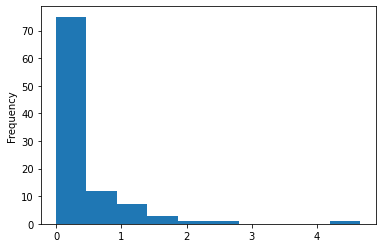

In [20]:
# Histograma dos erros
hist_plot = squared_errors.plot(kind='hist')

In [21]:
# Função para calcular o desvio padrão
def calc_desvio_padrao(variable, bias = 0):
    observations = float(len(variable))
    return np.sqrt(np.sum((variable - np.mean(variable))**2) / (observations - min(bias, 1)))

In [22]:
# Imprimindo o desvio padrão via fórmula e via NumPy
print ('Resultado da Função: %0.5f Resultado do Numpy: %0.5f' % (calc_desvio_padrao(dataset['lamb_initial']), np.std(dataset['lamb_initial'])))

Resultado da Função: 0.41972 Resultado do Numpy: 0.41972


In [23]:
# Funções para calcular a variância e a correlação
def covariance(variable_1, variable_2, bias = 0):
    observations = float(len(variable_1))
    return np.sum((variable_1 - np.mean(variable_1)) * (variable_2 - np.mean(variable_2))) / (observations - min(bias,1))

def standardize(variable):
    return (variable - np.mean(variable)) / np.std(variable)

def correlation(var1, var2, bias = 0):
    return covariance(standardize(var1), standardize(var2), bias)

In [26]:
# Compara o resultado das nossas funções com a função pearsonr do SciPy
from scipy.stats.stats import pearsonr
print ('Nossa estimativa de Correlação: %0.5f' % (correlation(dataset['lamb_initial'], dataset['target'])))
print ('Correlação a partir da função pearsonr do SciPy: %0.5f' % pearsonr(dataset['lamb_initial'], dataset['target'])[0])

Nossa estimativa de Correlação: 0.71079
Correlação a partir da função pearsonr do SciPy: 0.71079


In [27]:
# Definindo o range dos valores de x e y
x_range = [dataset['lamb_initial'].min(),dataset['lamb_initial'].max()]
y_range = [dataset['target'].min(),dataset['target'].max()]

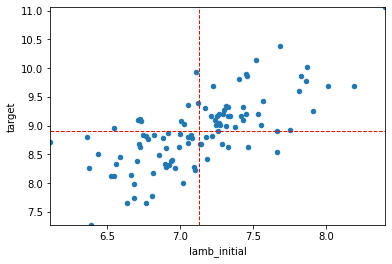

In [28]:
# Plot dos valores de x e y com a média
scatter_plot = dataset.plot(kind = 'scatter', x = 'lamb_initial', y = 'target', xlim = x_range, ylim = y_range)

# Cálculo da média
meanY = scatter_plot.plot(x_range, [dataset['target'].mean(),dataset['target'].mean()], '--', color = 'red', linewidth = 1)
meanX = scatter_plot.plot([dataset['lamb_initial'].mean(), dataset['lamb_initial'].mean()], y_range, '--', color = 'red', linewidth = 1)

## Regressão Linear com o StatsModels

In [29]:
# Importando as funções
import statsmodels.api as sm
import statsmodels.formula.api as smf # (simula a criação do modelo em linguagem R )

In [30]:
# Gerando X e Y. Vamos adicionar a constante ao valor de X, gerando uma matrix.
y = dataset['target']
X = dataset['lamb_initial']

# Esse comando adiciona os valores dos coefientes à variável X (o bias será calculado internamente pela função)
X = sm.add_constant(X)

In [31]:
X.head()

,const,lamb_initial
0,1.0,6.109416
1,1.0,7.223302
2,1.0,7.552879
3,1.0,6.545312
4,1.0,7.052870


In [34]:
# Essa alternativa é muito similar ao código equivalente em linguagem R
modelo_v1 = smf.ols(formula = 'target ~ lamb_initial', data = dataset)
modelo_v2 = modelo_v1.fit()

In [35]:
# Criando um modelo Ordinary Least Squares (outra forma de se referir a regressão linear)
modelo_v1 = sm.OLS(y, X)
modelo_v2 = modelo_v1.fit()
modelo_v2.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:                 target   R-squared:                       0.505
Model:                            OLS   Adj. R-squared:                  0.500
Method:                 Least Squares   F-statistic:                     100.1
Date:                Thu, 18 Jun 2020   Prob (F-statistic):           1.19e-16
Time:                        19:01:12   Log-Likelihood:                -58.443
No. Observations:                 100   AIC:                             120.9
Df Residuals:                      98   BIC:                             126.1
Df Model:                           1                                         
Covariance Type:            nonrobust                                         
================================================================================
                   coef    std err          t      P>|t|      [0.025      0.975]
--------------------------------------------------------------------------------
const            1.4516      0.746      1.947      0.054      -0.028       2.931
lamb_initial     1.0451      0.104     10.003      0.000       0.838       1.252
==============================================================================
Omnibus:                        0.512   Durbin-Watson:                   1.635
Prob(Omnibus):                  0.774   Jarque-Bera (JB):                0.663
Skew:                           0.115   Prob(JB):                        0.718
Kurtosis:                       2.674   Cond. No.                         124.
==============================================================================

Warnings:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
"""

In [36]:
# Imprimindo os Parâmetros
print (modelo_v2.params)

const           1.451606
lamb_initial    1.045080
dtype: float64


In [37]:
# Gerando os valores previstos
valores_previstos = modelo_v2.predict(X)
valores_previstos

0     7.836433
1     9.000532
2     9.344966
3     8.291979
4     8.822417
        ...   
95    8.707342
96    8.679953
97    8.915452
98    9.054837
99    9.717830
Length: 100, dtype: float64

In [38]:
# Fazendo previsões
lamb_initial = 8
Xp = np.array([1, lamb_initial])
print ("Se lamb_initial = %01.f nosso modelo prevê que a mediana da taxa de ocupação é %0.1f" % (lamb_initial, modelo_v2.predict(Xp)))

Se lamb_initial = 8 nosso modelo prevê que a mediana da taxa de ocupação é 9.8


### Gerando um ScatterPlot com a Linha de Regressão

In [39]:
# Range de valores para x e y
x_range = [dataset['lamb_initial'].min(),dataset['lamb_initial'].max()]
y_range = [dataset['target'].min(),dataset['target'].max()]

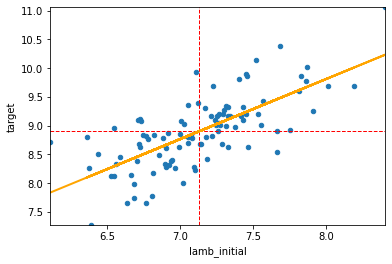

In [40]:
# Primeira camada do Scatter Plot
scatter_plot = dataset.plot(kind = 'scatter', x = 'lamb_initial', y = 'target', xlim = x_range, ylim = y_range)

# Segunda camada do Scatter Plot (médias)
meanY = scatter_plot.plot(x_range, [dataset['target'].mean(),dataset['target'].mean()], '--', color = 'red', linewidth = 1)
meanX = scatter_plot.plot([dataset['lamb_initial'].mean(),dataset['lamb_initial'].mean()], y_range, '--', color = 'red', linewidth = 1)

# Terceira camada do Scatter Plot (linha de regressão)
regression_line = scatter_plot.plot(dataset['lamb_initial'], valores_previstos, '-', color = 'orange', linewidth = 2)

In [41]:
# Comparação entre a função predict() e a função dot()
coeficientes = np.array(modelo_v2.params)
previsoes_dot = np.dot(X, coeficientes)
print ("Usando a função predict(): %s" % valores_previstos[:10])
print ("Usando coeficientes e função dot: %s" % previsoes_dot[:10])

Usando a função predict(): 0    7.836433
1    9.000532
2    9.344966
3    8.291979
4    8.822417
5    8.273259
6    8.865274
7    8.844467
8    9.091742
9    8.123898
dtype: float64
Usando coeficientes e função dot: [7.83643253 9.0005321  9.34496631 8.29197856 8.82241709 8.27325909
 8.86527371 8.84446722 9.09174247 8.1238984 ]


In [42]:
# Gerando os resíduos
residuos = dataset['target'] - valores_previstos
residuos_normalizados = standardize(residuos)

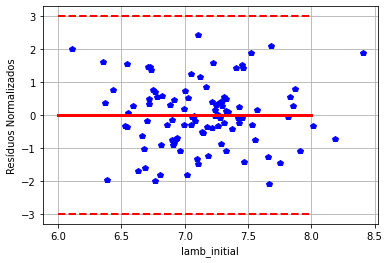

In [43]:
# ScatterPlot dos resíduos
residual_scatter_plot = plt.plot(dataset['lamb_initial'], residuos_normalizados,'bp')
plt.xlabel('lamb_initial') 
plt.ylabel('Resíduos Normalizados') 
mean_residual = plt.plot([int(x_range[0]),round(x_range[1],0)], [0,0], '-', color = 'red', linewidth = 3)
upper_bound = plt.plot([int(x_range[0]),round(x_range[1],0)], [3,3], '--', color = 'red', linewidth = 2)
lower_bound = plt.plot([int(x_range[0]),round(x_range[1],0)], [-3,-3], '--', color = 'red', linewidth = 2)
plt.grid()